In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from pyprojroot import here


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, desc
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType, DoubleType, DecimalType

In [3]:
PROJECT_ROOT_PATH = here()
# Ruta de almacenamiento row de la data
ROW_DATA_PATH = PROJECT_ROOT_PATH.joinpath("data", "row")
MASTER_DATA_PATH = PROJECT_ROOT_PATH.joinpath("data", "master")

In [4]:
import findspark
findspark.init()

In [5]:
# Creando unsa sesion de Spark
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("sql-avanzado") \
    .getOrCreate()
spark

## Agregaciones

* La realizacion de análisis interesantes sobre Big Data generalmente implica algun tipo de agregacion para resumir los datos con el fin de extraer patrones o conocimientos o genera informes resumidos.
* Las agregaciones requienren generalmente de alguna forma de agrupacion, ya sean en todo el conjunto de datos o uno o más columnas, luego aplican funciones de agregacion como sumar, contar o promediar a cada grupo.
* Spark admite diferente niveles de agrupación de fila:
    * Tratar un dataframe como un grupo.
    * Dividir un DataFrame en varios grupos utlizando una o más columnas y realizar una o más agregaciones en cada uno de esos grupos.
    * Dividir un DataFrame en varias ventanas y realizar una media móvil, una suma acumulativa o una clasificación.
* En spark todas las agregaciones se realizan a través de funciones.
* Las funciones de agregacion están diseñadas para realizar la agregacion en un conjunto de filas, yasea que ese conjunto de filas consista en todas las filas o enun subgrupo de filas en un DataFrame.

In [6]:
flight_df = spark\
            .read\
            .option("header", "true")\
            .csv(str(ROW_DATA_PATH.joinpath("flights.csv")))

flight_df.show(3, False)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

## Funciones ``count``, ``countDistinct`` y ``approx_count_distinct``

* La función ``count`` es la más eficiente ya que simplemente cuenta el número total de filas en el DataFrame y no implica estimaciones ni cálculos complejos.
* Si necesitas una estimación rápida y aceptable del número de valores distintos en una columna, ``approx_count_distinct`` puede ser más eficiente en términos de rendimiento, especialmente en conjuntos de datos grandes, ya que utiliza algoritmos aproximados.

```count```:

* Descripción: La función count cuenta el número total de filas en un DataFrame.
* Parámetros: No toma parámetros adicionales.
* Ejemplo:

In [7]:
dataframe = spark.read.parquet(str(ROW_DATA_PATH.joinpath("dataframe.parquet")))
dataframe.show()

+------+-----+--------+
|nombre|color|cantidad|
+------+-----+--------+
|  Jose| azul|    1900|
|  null| null|    1700|
|  null| rojo|    1300|
|  Juan| rojo|    1500|
+------+-----+--------+



In [8]:
from pyspark.sql.functions import count

In [9]:
dataframe.select(
    count(col("nombre")).alias("conteo_nombre"),
    count(col("color")).alias("conteo_color"),
).show()

+-------------+------------+
|conteo_nombre|conteo_color|
+-------------+------------+
|            2|           3|
+-------------+------------+



In [10]:
# Conteo general / de todos los registros
dataframe.select(
    count(col("nombre")).alias("conteo_nombre"),
    count(col("color")).alias("conteo_color"),
    count(col("*")).alias("conteo_general"), # Incluye todas las filas del dataframe
).show()

+-------------+------------+--------------+
|conteo_nombre|conteo_color|conteo_general|
+-------------+------------+--------------+
|            2|           3|             4|
+-------------+------------+--------------+



In [11]:
dataframe.count()

4

```countDistinct```:

* Descripción: La función countDistinct cuenta el número de valores distintos en una columna específica.
* Parámetros: Toma una columna como argumento.
* Ejemplo:

In [12]:
from pyspark.sql.functions import countDistinct

In [13]:
dataframe.select(
    countDistinct("color").alias("colores_diferentes") # siempre obvia el valor Null como valor diferente
).show()

+------------------+
|colores_diferentes|
+------------------+
|                 2|
+------------------+



``approx_count_distinct``:

* Descripción: La función approx_count_distinct proporciona una estimación aproximada del número de valores distintos en una columna, utilizando algoritmos de conteo distintos más eficientes en grandes conjuntos de datos.
* Parámetros: Toma una columna y un parámetro de precisión (por defecto 0.05 para un 5% de error).
* Ejemplo:

In [14]:
from pyspark.sql.functions import approx_count_distinct

In [15]:
# Usamos el dataframe ya creado anteriormente
flight_df.select(
    countDistinct("AIRLINE").alias("conteo_dist_aerolineas"),
    approx_count_distinct("AIRLINE").alias("conteo_dist_aprox_aerolineas")
).show()

+----------------------+----------------------------+
|conteo_dist_aerolineas|conteo_dist_aprox_aerolineas|
+----------------------+----------------------------+
|                    14|                          13|
+----------------------+----------------------------+



## Funciones ``min`` y ``max``

In [16]:
from pyspark.sql.functions import min, max

In [17]:
# Sguimos usando el dataframe de vuelos
# Calculo del minimo y máximo tiempo en el aire que permanecieron los vuelos
flight_df.select(
    min(col("AIR_TIME")).alias("tiempo_minimo"),
    max(col("AIR_TIME")).alias("tiempo_maximo"),
).show()

+-------------+-------------+
|tiempo_minimo|tiempo_maximo|
+-------------+-------------+
|           10|           99|
+-------------+-------------+



In [18]:
flight_df.select(
    min("AIRLINE_DELAY"),
    max("AIRLINE_DELAY"),
).show()

+------------------+------------------+
|min(AIRLINE_DELAY)|max(AIRLINE_DELAY)|
+------------------+------------------+
|                 0|               998|
+------------------+------------------+



## Funciones ``sum``, ``sumDistinct`` y ``avg``

**Optimización:**
- La función `sum` es la más eficiente y simplemente suma todos los valores en la columna especificada.
- `sumDistinct` se utiliza cuando necesitas sumar solo los valores distintos en una columna numérica.
- La función `avg` calcula el promedio de los valores en una columna y es eficiente en términos de rendimiento.

In [19]:
from pyspark.sql.functions import sum, sumDistinct, avg

1. **`sum`**:
   - **Descripción:** La función `sum` calcula la suma total de los valores en una columna numérica.
   - **Parámetros:** Toma una columna numérica como argumento.
   - **Ejemplo:**

In [20]:
flight_df.select(
    sum("DISTANCE").alias("suma_distancia")
).show()

+--------------+
|suma_distancia|
+--------------+
| 4.785357409E9|
+--------------+



2. **`sumDistinct`**:
   - **Descripción:** La función `sumDistinct` calcula la suma total de los valores distintos en una columna numérica.
   - **Parámetros:** Toma una columna numérica como argumento.
   - **Ejemplo:**

In [21]:
flight_df.select(
    sumDistinct("DISTANCE").alias("sum_dis_dif")
).show()

+-----------+
|sum_dis_dif|
+-----------+
|  1442300.0|
+-----------+



3. **`avg`**:
   - **Descripción:** La función `avg` calcula el promedio de los valores en una columna numérica.
   - **Parámetros:** Toma una columna numérica como argumento.
   - **Ejemplo:**

In [22]:
flight_df.select(
    avg("AIR_TIME").alias("promedio_aire"),
    (sum(col("AIR_TIME")) / count("AIR_TIME")).alias("promedio_manual")
).show()

+------------------+------------------+
|     promedio_aire|   promedio_manual|
+------------------+------------------+
|113.51162809012519|113.51162809012519|
+------------------+------------------+



## Agregación con agrupacion

Las agregaciones generalmente se realizan en conjuntos de datos que contienen uno o más columnas categóricas, que tiene una cardinalidad baja.

En lugar de realiar las agregaciones en el Dataframe lo haremo en cada uno de los subgrupos dentro de un DataFrame.

Realizar agregacion con agrupacion es un proceso de dos pasos:
1. Realizar la agrupacion mediante la transformacion ``groupBy(col1, col2, ...)`` y es ahí donde se especifica por qué columnas agrupar las filas.

    A diferencia de otras transformaciones que devuelven un DataFrame la tranformacion groupBy() devuelve una isntancia de la clase Relational Grouped Datasetal que luego se puede aplicar una o más funciones de agregacion.

2. Agregar las funciones de agregación deseadas.

In [26]:
flight_df.printSchema()

root
 |-- YEAR: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- DAY: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: string (nullable = true)
 |-- DEPARTURE_TIME: string (nullable = true)
 |-- DEPARTURE_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- SCHEDULED_TIME: string (nullable = true)
 |-- ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- SCHEDULED_ARRIVAL: string (nullable = true)
 |-- ARRIVAL_TIME: string (nullable = true)
 |-- ARRIVAL_DELAY: string (nullable = true)
 |-- D

In [31]:
from pyspark.sql.functions import desc

In [37]:
# Contar la cntidad de vuelos por aeropuestos origen (ORIGIN_AIRPORT) y mostra en order descendente.
flight_df.groupBy(col("ORIGIN_AIRPORT"))\
    .count()\
    .orderBy(desc(col("count")))\
    .show()

+--------------+------+
|ORIGIN_AIRPORT| count|
+--------------+------+
|           ATL|346836|
|           ORD|285884|
|           DFW|239551|
|           DEN|196055|
|           LAX|194673|
|           SFO|148008|
|           PHX|146815|
|           IAH|146622|
|           LAS|133181|
|           MSP|112117|
|           MCO|110982|
|           SEA|110899|
|           DTW|108500|
|           BOS|107847|
|           EWR|101772|
|           CLT|100324|
|           LGA| 99605|
|           SLC| 97210|
|           JFK| 93811|
|           BWI| 86079|
+--------------+------+
only showing top 20 rows



In [38]:
# Agrupacion multiples columnas
flight_df.groupBy("ORIGIN_AIRPORT", "DESTINATION_AIRPORT")\
    .count()\
    .orderBy(desc("count"))\
    .show()

+--------------+-------------------+-----+
|ORIGIN_AIRPORT|DESTINATION_AIRPORT|count|
+--------------+-------------------+-----+
|           SFO|                LAX|13744|
|           LAX|                SFO|13457|
|           JFK|                LAX|12016|
|           LAX|                JFK|12015|
|           LAS|                LAX| 9715|
|           LGA|                ORD| 9639|
|           LAX|                LAS| 9594|
|           ORD|                LGA| 9575|
|           SFO|                JFK| 8440|
|           JFK|                SFO| 8437|
|           OGG|                HNL| 8313|
|           HNL|                OGG| 8282|
|           LAX|                ORD| 8256|
|           ATL|                LGA| 8234|
|           LGA|                ATL| 8215|
|           ATL|                MCO| 8202|
|           MCO|                ATL| 8202|
|           SFO|                LAS| 7995|
|           ORD|                LAX| 7941|
|           DFW|                ORD| 7870|
+----------

* **Varias agregaciones por grupo**

In [43]:
from pyspark.sql.functions import sum, min, max, desc, avg

In [58]:
#Agrupar por el aeropuerto y se quiere saber el conteo o canitadad del tiempo que estuvo en el aire todos esos vuelos, ademnás se quiere saber el mínimo y máximo que se tardaron esos vuelo en el aire y ordenados de forma descendente por el tiempo de vuelo ques estuvieron esos vuelos.

flight_df.groupBy("ORIGIN_AIRPORT").agg(
    sum(col("AIR_TIME") / (60*24)).alias("tiempo_aire"), 
    min("AIR_TIME").alias("minimo_tiempo_aire"),
    max("AIR_TIME").alias("maximo_aire_tiempo")
).orderBy(desc(col("tiempo_aire"))).show()

+--------------+------------------+------------------+------------------+
|ORIGIN_AIRPORT|       tiempo_aire|minimo_tiempo_aire|maximo_aire_tiempo|
+--------------+------------------+------------------+------------------+
|           ATL|21884.972916666993|               100|                99|
|           LAX|20737.483333332628|               100|                99|
|           ORD|19551.102777778062|               100|                99|
|           DFW|  17302.5250000002|               100|                99|
|           DEN|15384.775694444763|               100|                99|
|           SFO|15022.761111111187|               100|                99|
|           JFK|12745.747222222291|               100|                99|
|           PHX|12508.488194444299|               100|                99|
|           SEA|12255.443055555617|               100|                99|
|           LAS|11511.350694444853|               100|                99|
|           IAH|11227.100000000008|   

In [59]:
# Agrupar por  mes/mount y ver la cantidad de vuelos que arrivaron con retraso
flight_df.groupBy(col("MONTH")).agg(
    count("ARRIVAL_DELAY").alias("conteo_de_retrasos"),
    avg(col("DISTANCE")).alias("distancia")
).orderBy(desc(col("conteo_de_retrasos"))).show()

+-----+------------------+-----------------+
|MONTH|conteo_de_retrasos|        distancia|
+-----+------------------+-----------------+
|    7|            514384|841.4772794487611|
|    8|            503956|834.8244276603413|
|    6|            492847|835.6302716626612|
|    3|            492138|816.0553268611494|
|    5|            489641|823.3230588760807|
|   10|            482878|816.4436127652134|
|    4|            479251|817.0060476016745|
|   12|            469717|837.8018926194103|
|   11|            462367|820.2482434846529|
|    9|            462153|815.8487523282274|
|    1|            457013|803.2612794913696|
|    2|            407663| 800.785449834689|
+-----+------------------+-----------------+



### Agregacion con Pivote

In [62]:
students_df = spark.read.parquet(str(ROW_DATA_PATH.joinpath("estudiantes.parquet")))
students_df.show()

+------+----+----+----------+
|nombre|sexo|peso|graduacion|
+------+----+----+----------+
|  Jose|   M|  80|      2000|
| Hilda|   F|  50|      2000|
|  Juan|   M|  75|      2000|
| Pedro|   M|  76|      2001|
|Katia+|   F|  65|      2001|
+------+----+----+----------+



In [63]:
from pyspark.sql.functions import min, max, avg, col

In [69]:
# Hallar el promedio de pesos por año de graduacion y sexo
students_df.groupBy(col("graduacion")).pivot("sexo").agg(avg("peso")).show()

+----------+----+----+
|graduacion|   F|   M|
+----------+----+----+
|      2001|65.0|76.0|
|      2000|50.0|77.5|
+----------+----+----+



In [71]:
# El numeor de columnas que se obtiene  en el dataframe es el producto los valores unicos de la columna pivote y el numero de agregaciones que se realzia.

students_df.groupBy(col("graduacion"))\
    .pivot("sexo")\
    .agg(avg("peso"), max("peso"), min("peso"))\
    .show()

+----------+-----------+-----------+-----------+-----------+-----------+-----------+
|graduacion|F_avg(peso)|F_max(peso)|F_min(peso)|M_avg(peso)|M_max(peso)|M_min(peso)|
+----------+-----------+-----------+-----------+-----------+-----------+-----------+
|      2001|       65.0|         65|         65|       76.0|         76|         76|
|      2000|       50.0|         50|         50|       77.5|         80|         75|
+----------+-----------+-----------+-----------+-----------+-----------+-----------+



* **Importante**:
Cuando especifiquemos un subconjunto de loa valores unicos de la columna/variable pivote, lo que pyspark es acelelrar el proceso de rotacion de las columnas (acelera el proceso de pivoteo) de loc ontrario spark dedicará algo de tiempo para encontrar una lista de los valores únicos antes de todo el pivoteo.

In [74]:
# Se puede especficar un subconjunto de los valores unicos del pivote en este caso solo del masculino M
students_df.groupBy(col("graduacion"))\
    .pivot("sexo", ["M"])\
    .agg(
        avg("peso").alias("peso_promedio_masculino"),
        max("peso").alias("peso_maximo_masculino"),
        min("peso").alias("peso_minimo_masculino"))\
    .show()

+----------+----------------+-----------------------+-----------+
|graduacion|M_peso_masculino|M_peso_maximo_masculino|M_min(peso)|
+----------+----------------+-----------------------+-----------+
|      2001|            76.0|                     76|         76|
|      2000|            77.5|                     80|         75|
+----------+----------------+-----------------------+-----------+



### Joins

Al realizar un join se combinarán las columnas de los dos conjuntos de datos, esto podría permitir una análisis profudno que si se hiciera de forma independiente.


### Expresion join y tipos de join

Realizar un join de dos conjutnos de datos requiere de dos piezas de información:

1. Expresion de join que especifica que columnas de cada conjutno de datos deben usarse para determinar qué filas de ambos conjuntos de datos se incluirán en el conjunto de datos combinado.
2. El tipo de join. Este determina qué se debe incluir en el conjunto de datos combiando.

Tipos de join adimitidos en SparkSQL:

* ``inner join``: devuelve filas de ambos conjutnos de datos cuando la expresion de join evalúa como verdadera.
* ``left outer join``: devuelve filas del conjunto de datos de la **izquierda** incluso cuando a expresion de jion se evalúa como falsa.
* ``right outer join``: devuelve filas del conjunto de datos de la **derecha** incluso cuando a expresion de jion se evalúa como falsa.
* ``Outer join``: devuelve filas de ambos conjutnos de datos incluso cuando la expresion del join se evalúa como falsa.
* ``left anti join``: devuelve solo conjunto de datos de la izquierda cuando la expresión de jion se evalúa como falsa.
* ``left semi jion``: devuelve filas solo del conjutno de datos de la izquierda cuando la expresion del join se evalúa como falsa.
* ``cross``: devuelve filas combinando cada fila del conjunto de datos de la izquierda con cada fila del conjunto de datos de la derecha. El número de filas será un producto del tamaño de cada conjutno de datos.
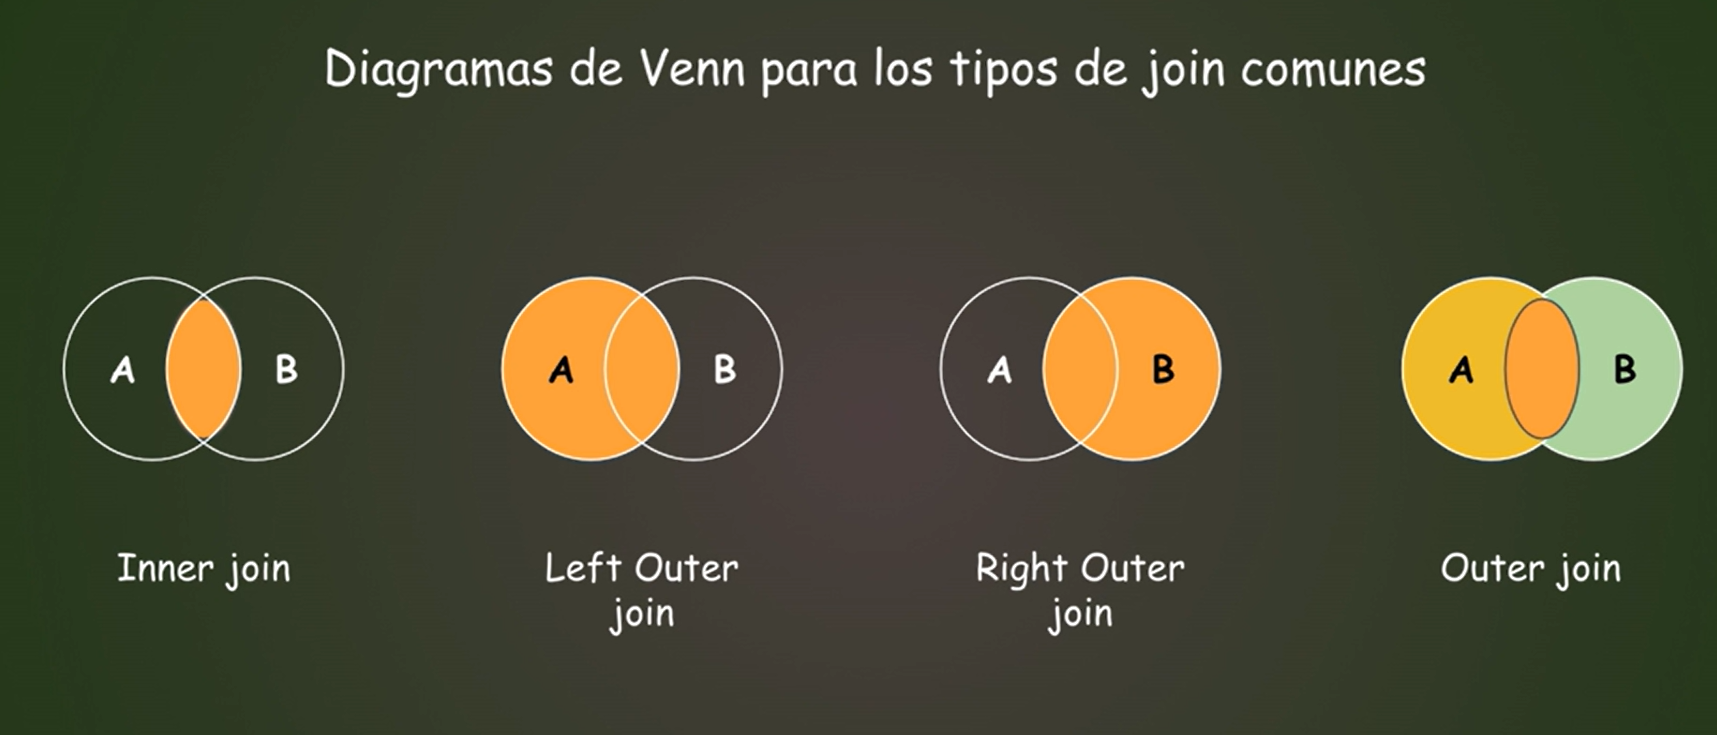 

#### 1. ``inner join``

In [83]:
departamentos = spark.read.option("header","true").parquet(str(ROW_DATA_PATH.joinpath("departamentos")))
empleados = spark.read.option("header","true").parquet(str(ROW_DATA_PATH.joinpath("empleados")))
# empleados.show(), departamentos.show()

In [ ]:
departamentos